In [258]:
from eval import analyze_model

import pandas as pd
import torch
import numpy as np
from pmf import PMF
from lr import LogReg
import pickle

SEED = 42
K_FOLDS = 5
REPLACEMENT_LEVELS = [25, 50, 100, 250, 500, 1000]
LATENT_FACTORS = [1, 2, 3, 4, 5, 6]

In [228]:
df = pd.read_csv('data/men_data.csv')

from sklearn.model_selection import KFold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    for replacement_level in REPLACEMENT_LEVELS:
        with open(f"models/lr/model_rl_{replacement_level}_fold_{fold}.pkl", 'rb') as f:
            lr_model = pickle.load(f)
        for num_factors in LATENT_FACTORS:
            results.append({
                'model_type': 'lr',
                'replacement_level': replacement_level,
                'num_factors': num_factors,
                'fold': fold,
                'train_results': analyze_model(lr_model, train),
                'test_results': analyze_model(lr_model, test)
            })

        for num_factors in LATENT_FACTORS:
            pmf_model = torch.load(f"models/pmf/model_rl_{replacement_level}_d_{num_factors}_fold_{fold}.pth")
            pmf_model.eval()
            results.append({
                'model_type': 'pmf',
                'replacement_level': replacement_level,
                'num_factors': num_factors,
                'fold': fold,
                'train_results': analyze_model(pmf_model, train),
                'test_results': analyze_model(pmf_model, test)
            })

results = pd.DataFrame(results)
results

,model_type,replacement_level,num_factors,fold,train_results,test_results
0,lr,25,1,0,"{'Accuracy': 0.67902660558888, 'Log Loss': 0.6...","{'Accuracy': 0.6725468577728776, 'Log Loss': 0..."
1,lr,25,2,0,"{'Accuracy': 0.67902660558888, 'Log Loss': 0.6...","{'Accuracy': 0.6725468577728776, 'Log Loss': 0..."
2,lr,25,3,0,"{'Accuracy': 0.67902660558888, 'Log Loss': 0.6...","{'Accuracy': 0.6725468577728776, 'Log Loss': 0..."
3,lr,25,4,0,"{'Accuracy': 0.67902660558888, 'Log Loss': 0.6...","{'Accuracy': 0.6725468577728776, 'Log Loss': 0..."
4,lr,25,5,0,"{'Accuracy': 0.67902660558888, 'Log Loss': 0.6...","{'Accuracy': 0.6725468577728776, 'Log Loss': 0..."
...,...,...,...,...,...,...
355,pmf,1000,2,4,"{'Accuracy': 0.7502100068252218, 'Log Loss': 0...","{'Accuracy': 0.7261892260842172, 'Log Loss': 0..."
356,pmf,1000,3,4,"{'Accuracy': 0.7523757022103218, 'Log Loss': 0...","{'Accuracy': 0.7264517483986139, 'Log Loss': 0..."
357,pmf,1000,4,4,"{'Accuracy': 0.7528875938468, 'Log Loss': 0.48...","{'Accuracy': 0.7275543421190801, 'Log Loss': 0..."
358,pmf,1000,5,4,"{'Accuracy': 0.7514700477765527, 'Log Loss': 0...","{'Accuracy': 0.7273968287304421, 'Log Loss': 0..."


In [259]:
metrics = pd.concat([
    pd.concat(
        [
            results[['model_type', 'replacement_level', 'num_factors', 'fold']],
            results['train_results'].apply(pd.Series).assign(dataset = "train")
        ], axis = 1
    ),
    pd.concat(
        [
            results[['model_type', 'replacement_level', 'num_factors', 'fold']],
            results['test_results'].apply(pd.Series).assign(dataset = "test")
        ], axis = 1
    )
])

metrics.head()

,model_type,replacement_level,num_factors,fold,Accuracy,Log Loss,Brier Score,F1 Score,ROC Score,dataset
0,lr,25,1,0,0.679027,0.606857,0.209202,0.73214,0.722125,train
1,lr,25,2,0,0.679027,0.606857,0.209202,0.73214,0.722125,train
2,lr,25,3,0,0.679027,0.606857,0.209202,0.73214,0.722125,train
3,lr,25,4,0,0.679027,0.606857,0.209202,0.73214,0.722125,train
4,lr,25,5,0,0.679027,0.606857,0.209202,0.73214,0.722125,train


In [254]:
metrics.query('model_type == "pmf" and replacement_level == 500 and num_factors == 3')

,model_type,replacement_level,num_factors,fold,Accuracy,Log Loss,Brier Score,F1 Score,ROC Score,dataset
56,pmf,500,3,0,0.783519,0.423829,0.142319,0.805381,0.876818,train
128,pmf,500,3,1,0.783231,0.424860,0.142717,0.806899,0.876104,train
200,pmf,500,3,2,0.784294,0.422455,0.141799,0.806162,0.877631,train
272,pmf,500,3,3,0.783953,0.422652,0.141919,0.805364,0.877526,train
344,pmf,500,3,4,0.784559,0.421581,0.141564,0.805949,0.877994,train
56,pmf,500,3,0,0.741324,1.090262,0.181789,0.767561,0.806132,test
128,pmf,500,3,1,0.740012,1.170565,0.185061,0.767490,0.800453,test
200,pmf,500,3,2,0.732924,1.110886,0.185030,0.757635,0.799885,test
272,pmf,500,3,3,0.748412,1.000474,0.177798,0.776534,0.812632,test
344,pmf,500,3,4,0.742728,1.092463,0.182348,0.766154,0.804714,test


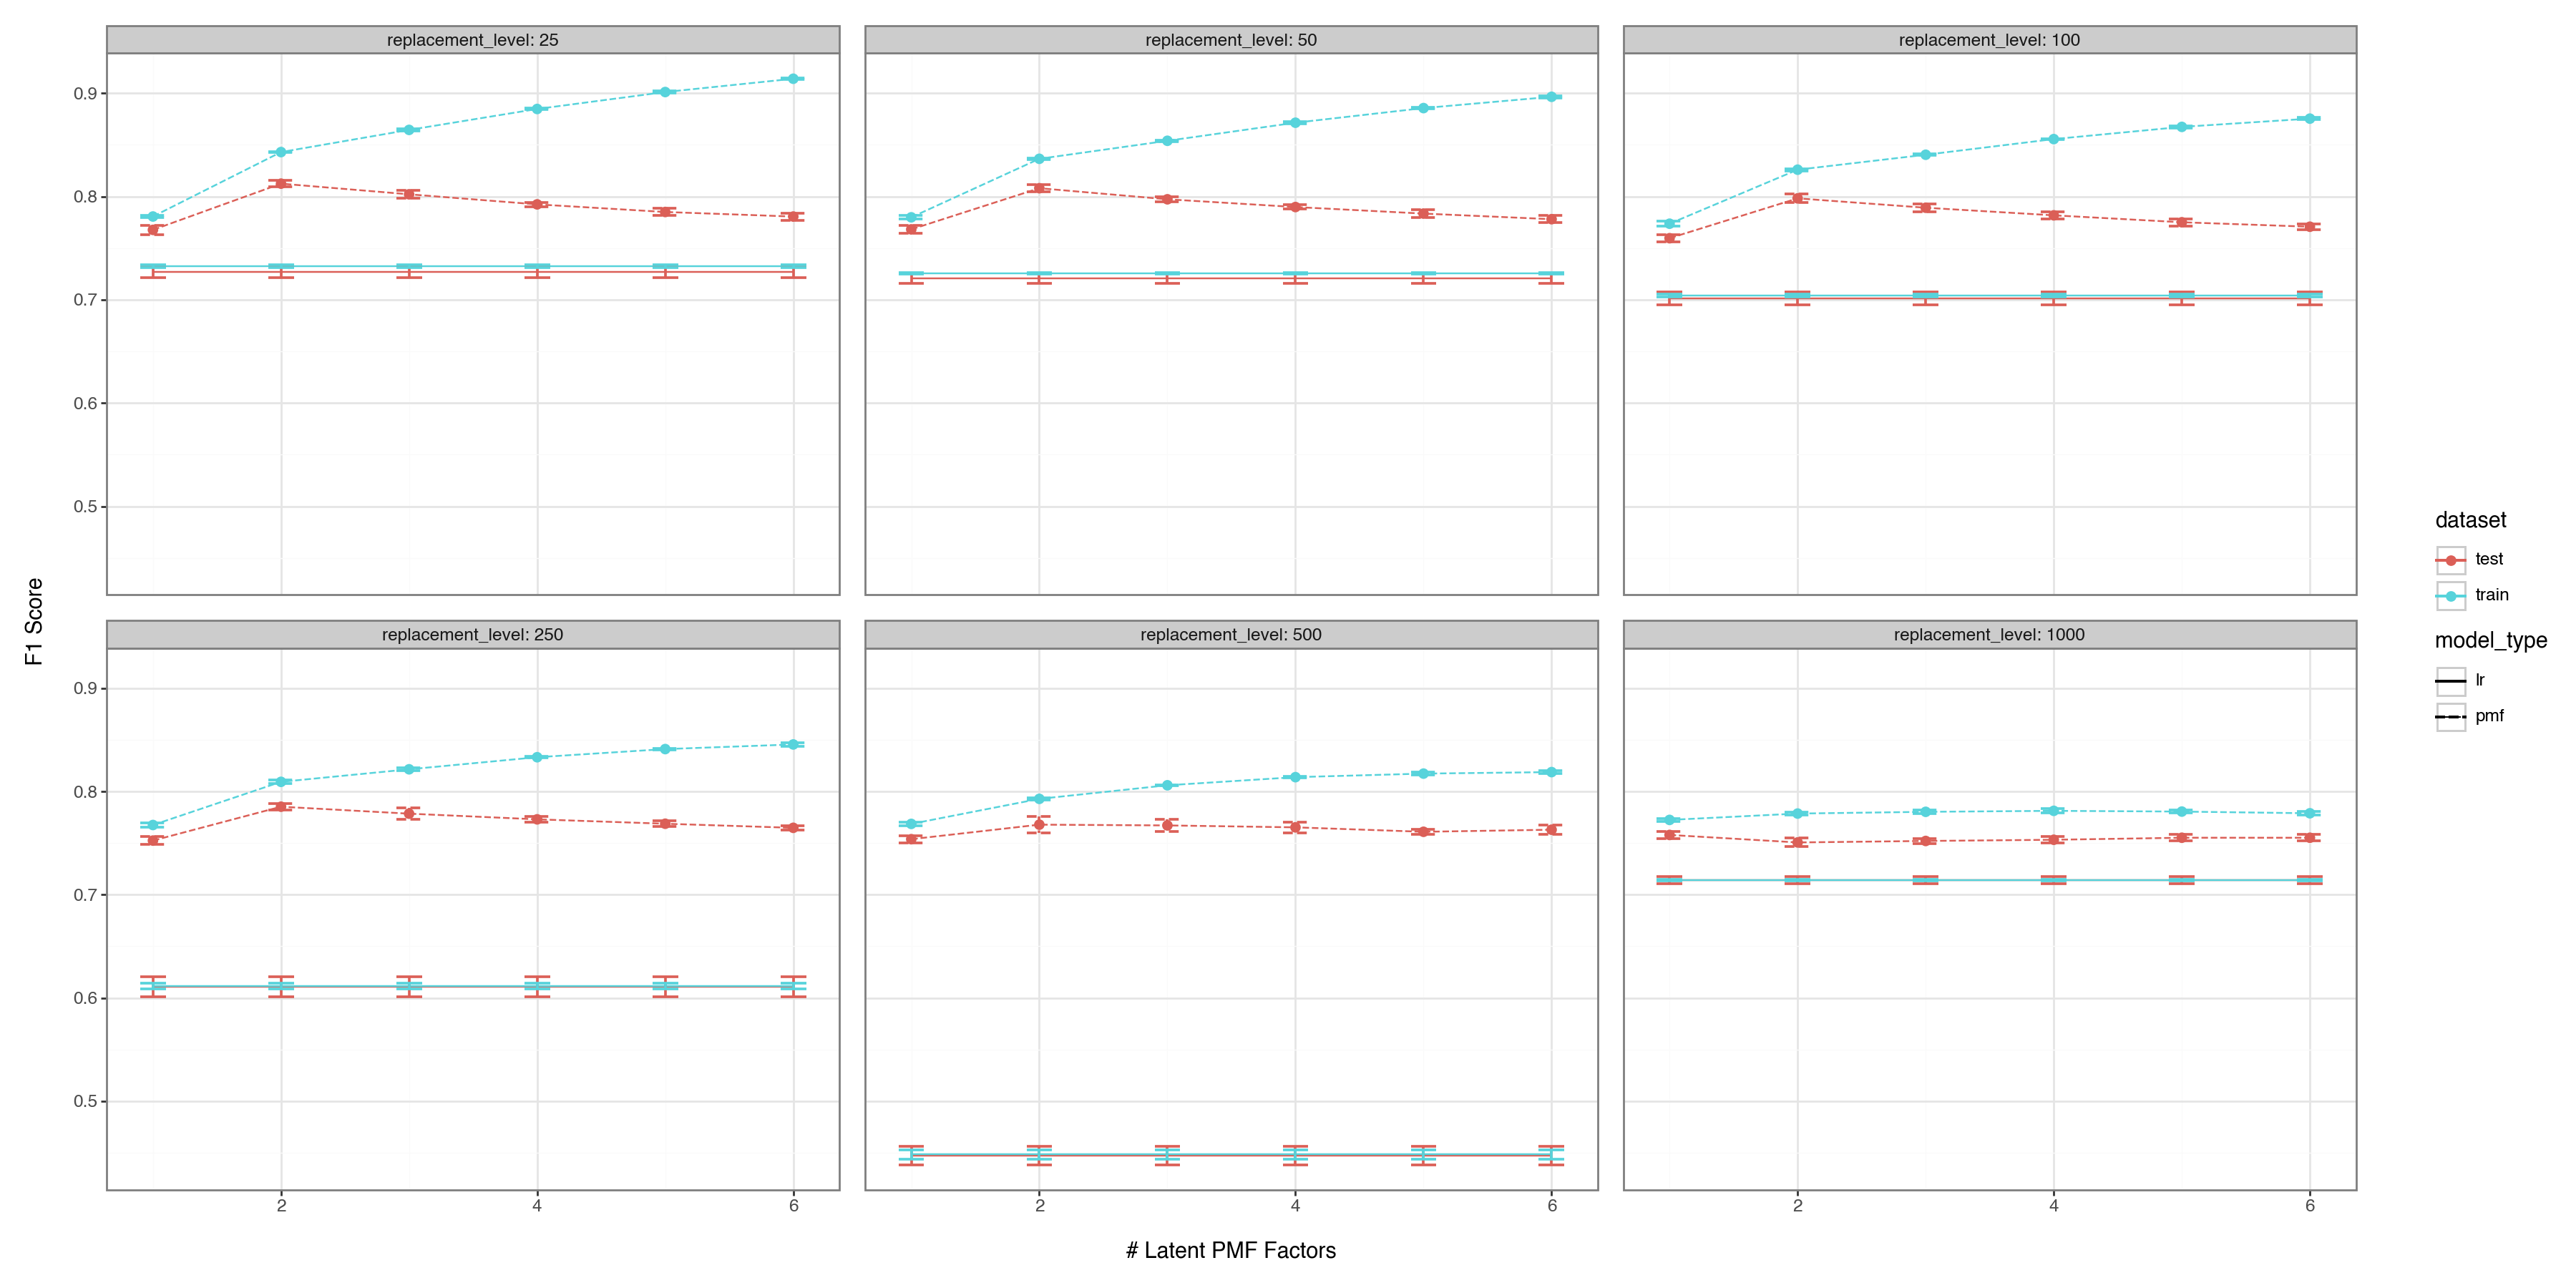

In [257]:
import plotnine
from plotnine import *

plot_data = (
    metrics
    .groupby(['model_type', 'replacement_level', 'num_factors', 'dataset'])
    ['F1 Score'].agg(['mean', 'std', 'size'])
    .reset_index()
    .assign(
        se = lambda d: d['std'] / d['size'].apply(np.sqrt),
        mean_err_min = lambda d: d['mean'] - 1.96 * d.se,
        mean_err_max = lambda d: d['mean'] + 1.96 * d.se
    )
)

plotnine.options.figure_size = (18,9)
p = (
  plot_data
  .pipe(ggplot, aes(x = "num_factors", y = "mean", color = "dataset", linetype = "model_type")) +
  # Add horizontal lines for logistic regression
  # geom_hline(aes(yintercept = "mean", color = "dataset"), data = plot_data.query("model_type == 'lr'")) +
  # Add lines and points for PMF
  geom_line() +
  geom_errorbar(aes(ymin = "mean_err_min", ymax = "mean_err_max"), width = 0.2, size = 0.75) +
  geom_point(size = 2, data = plot_data.query("model_type == 'pmf'")) +
  facet_wrap("~ replacement_level", labeller="label_both") +
  labs(x = "# Latent PMF Factors", y = "F1 Score") +
  theme_bw()
)


p